### Deformation Field Overlaying into the Moving Image

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from   natsort import natsorted
from scipy.ndimage import gaussian_filter, map_coordinates

In [2]:
# Function to get the deformation field and moving images
def get_file_paths(directory):
    file_types = {
        'img2.nii.gz'   : [],
        'seg2.nii.gz'   : [],
        'w_img.nii.gz'  : [],
        'w_seg.nii.gz'  : [],
        'flow_4d.nii.gz': [],
        
    }
    
    for filename in os.listdir(directory):
        for file_suffix in file_types:
            if filename.endswith(file_suffix):
                file_types[file_suffix].append(os.path.join(directory, filename))
                break
    for key in file_types:
        file_types[key] = natsorted(file_types[key])
    
    return file_types

In [3]:
def load_nifti_image(file_path):
    nii   = nib.load(file_path)
    image = nii.get_fdata()
    return image, nii.affine

In [4]:
def load_deformation_field(file_path):
    nii = nib.load(file_path)
    deformation_field = nii.get_fdata()
    return deformation_field

In [5]:
def draw_grid(image_shape, grid_spacing=10, grid_value=1):
    grid_image = np.zeros(image_shape)
    for i in range(0, image_shape[0], grid_spacing):
        grid_image[i, :, :] = grid_value
    for j in range(0, image_shape[1], grid_spacing):
        grid_image[:, j, :] = grid_value
    for k in range(0, image_shape[2], grid_spacing):
        grid_image[:, :, k] = grid_value
    return grid_image

In [6]:
def blur_grid(grid_image, sigma=0.25):
    blurred_grid = gaussian_filter(grid_image, sigma=sigma)
    return blurred_grid

In [7]:
def add_grid_to_image(image, grid_image):
    modified_image = image + grid_image
    return modified_image

In [8]:
def apply_deformation(image, deformation_field):
    # Split the deformation field into x, y, z components
    print('Deformation field in nii: ', deformation_field.shape)
    dx = deformation_field[:, :, :, 0]
    dy = deformation_field[:, :, :, 1]
    dz = deformation_field[:, :, :, 2]
    
    # Create a meshgrid of coordinates
    coords = np.meshgrid(np.arange(image.shape[0]), 
                         np.arange(image.shape[1]), 
                         np.arange(image.shape[2]), indexing='ij')
    
    # Apply the deformation field to the coordinates
    deformed_coords = [coords[0] + dx, 
                       coords[1] + dy, 
                       coords[2] + dz]
    
    # Interpolate the image at the new coordinates
    warped_image = map_coordinates(image, deformed_coords, order=1)
    return warped_image

In [9]:
# Function to visualize slices
def visualize_slices(data, title="Image Slices", slices=None):
    """
    Visualizes slices of a 3D image.

    Parameters:
    - data: 3D numpy array representing the image data.
    - title: Title for the plot.
    - slices: Tuple of three integers representing the indices of the slices 
              to visualize in the axial, coronal, and sagittal planes. 
              If None, the middle slices are used.
    """
    if slices is None:
        slices = (data.shape[0] // 2, data.shape[1] // 2, data.shape[2] // 2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)

    # Axial slice (viewed from the top of the head)
    axes[0].imshow(data[slices[0], :, :].T, cmap='gray', origin='lower')
    axes[0].set_title(f'Sagital slice {slices[0]}')
    
    # Coronal slice (viewed from the front)
    axes[1].imshow(data[:, slices[1], :].T, cmap='gray', origin='lower')
    axes[1].set_title(f'Coronal slice {slices[1]}')

    # Sagittal slice (viewed from the side)
    axes[2].imshow(data[:, :, slices[2]].T, cmap='gray', origin='lower')
    axes[2].set_title(f'Axial slice {slices[2]}')
    plt.show()

In [10]:
def main(image_path, seg_path, warp_img_path, warp_seg_path, deformation_path, output_path, grid_spacing=10, sigma=0.5):
    # Step1: Loading the moving image and the deformation field in 4d
    image, affine    = load_nifti_image(image_path)
    segm,  affine    = load_nifti_image(seg_path)
    warpped_image, _ = load_nifti_image(warp_img_path)
    warpped_segm,  _ = load_nifti_image(warp_seg_path)
    def_field_4d     = load_deformation_field(deformation_path)
    
    # Step2: Drawing and bluring the grid
    grid_image   = draw_grid(image.shape, grid_spacing=grid_spacing)
    blurred_grid = blur_grid(grid_image, sigma=sigma)
    
    # Step3: Adding the grid to the moving image
    modified_image = add_grid_to_image(image, blurred_grid)
    modified_segm  = add_grid_to_image(segm, blurred_grid)
    
    # Step4: Applying the deformation field to the moving image
    warped_image = apply_deformation(modified_image, def_field_4d)
    warped_segm  = apply_deformation(modified_segm, def_field_4d)
    
    # Step5: Visualizing moving image outputs
    visualize_slices(image, title='Moving Image')
    visualize_slices(modified_image, title='Moving Image with Blurred Grid')
    print(warped_image.shape)
    print(warpped_image.shape)
    visualize_slices(warped_image,   title='Deformed Moving Image with Blurred Grid')
    visualize_slices(warpped_image,   title='Deformed Moving Image - Output Model')
    
    # Step6: Visualizing moving segmentation outputs
    visualize_slices(segm, title='Moving Segmenation')
    visualize_slices(modified_segm, title='Moving Segmentation with Blurred Grid')
    visualize_slices(warped_segm,   title='Deformed Moving Segmentation with Blurred Grid')
    visualize_slices(warpped_segm,   title='Deformed Moving Segmentation - Output Model')
    
      

##### VoxelMorph

In [11]:
# VoxelMorph Directory
vxm_directory    = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Jul31-053533_Abtrain_VXMx1___/'
vxm_defGrid_dir  = vxm_directory + 'defGrid_figures/'
image_paths   = get_file_paths(vxm_directory)
img2_paths    = image_paths['img2.nii.gz']
seg2_paths    = image_paths['seg2.nii.gz']
w_img_paths   = image_paths['w_img.nii.gz']
w_seg_paths   = image_paths['w_seg.nii.gz']
flow_4d_paths = image_paths['flow_4d.nii.gz']

img2_0_paths    = img2_paths[0]
seg2_0_paths    = seg2_paths[0]
w_img_0_paths   = w_img_paths[0]
w_seg_0_paths   = w_seg_paths[0]
flow_4d_0_paths = flow_4d_paths[0]

img2_54_paths    = img2_paths[54]
seg2_54_paths    = seg2_paths[54]
w_img_54_paths   = w_img_paths[54]
w_seg_54_paths   = w_seg_paths[54]
flow_4d_54_paths = flow_4d_paths[54]

Deformation field in nii:  (192, 160, 256, 3)
Deformation field in nii:  (192, 160, 256, 3)


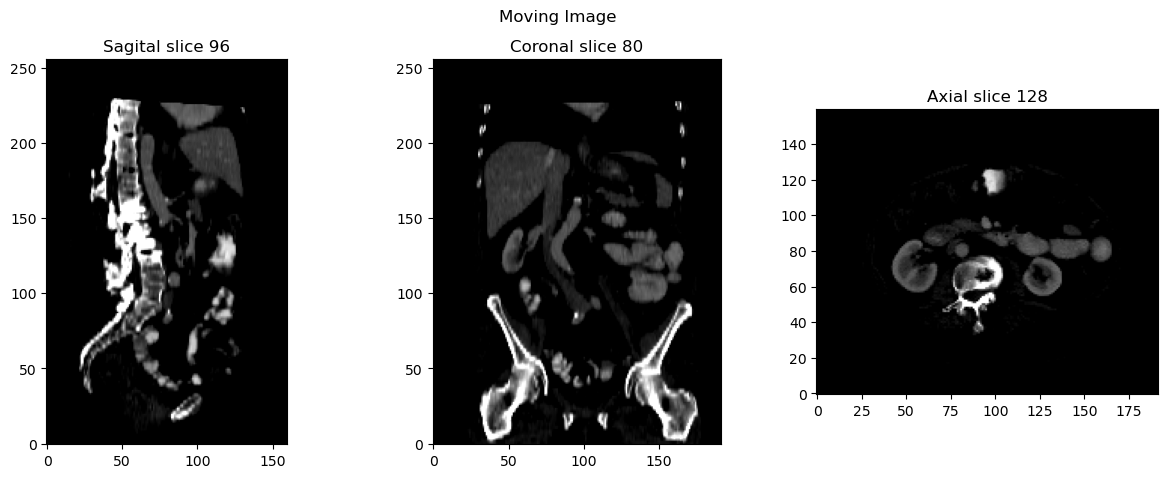

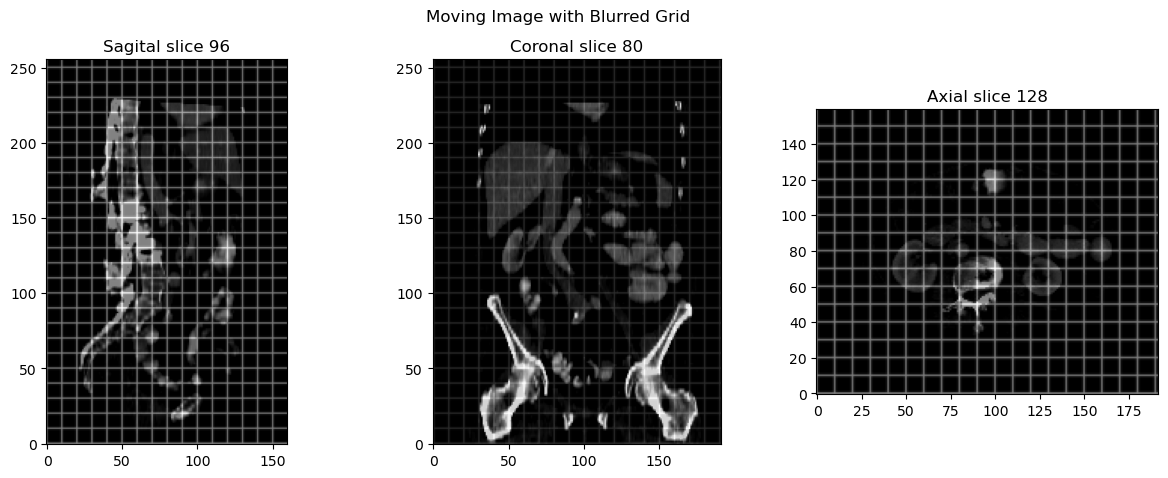

(192, 160, 256)
(192, 160, 256)


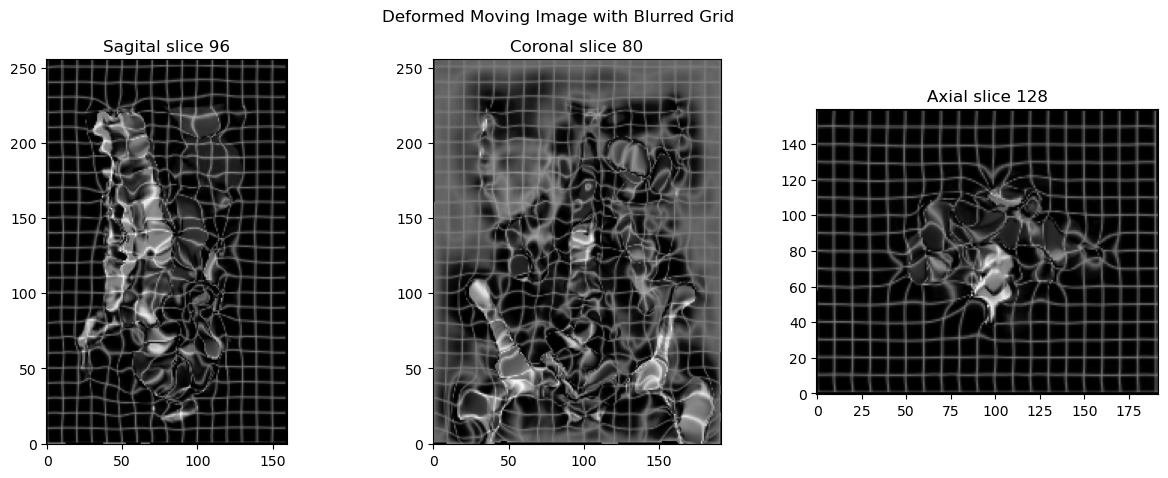

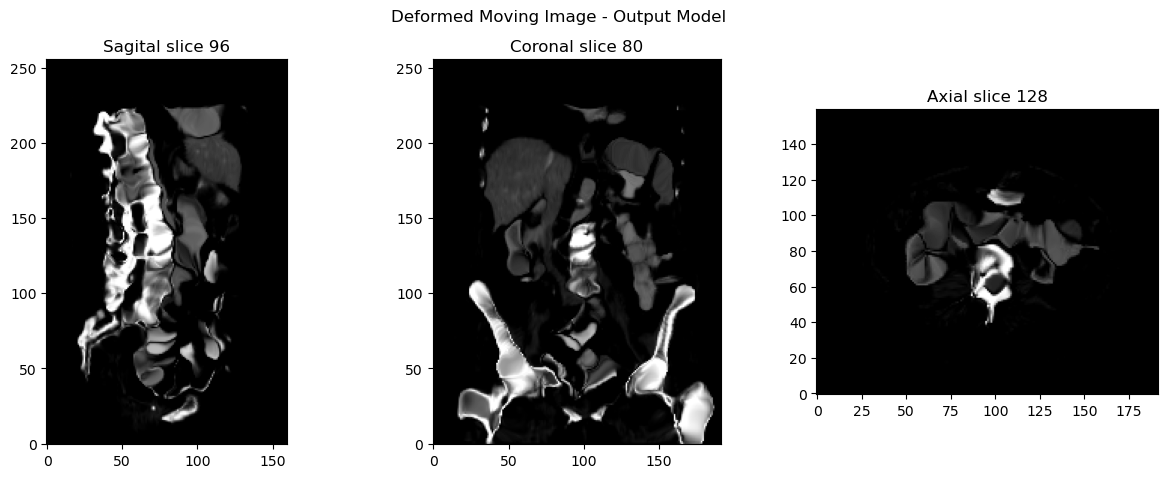

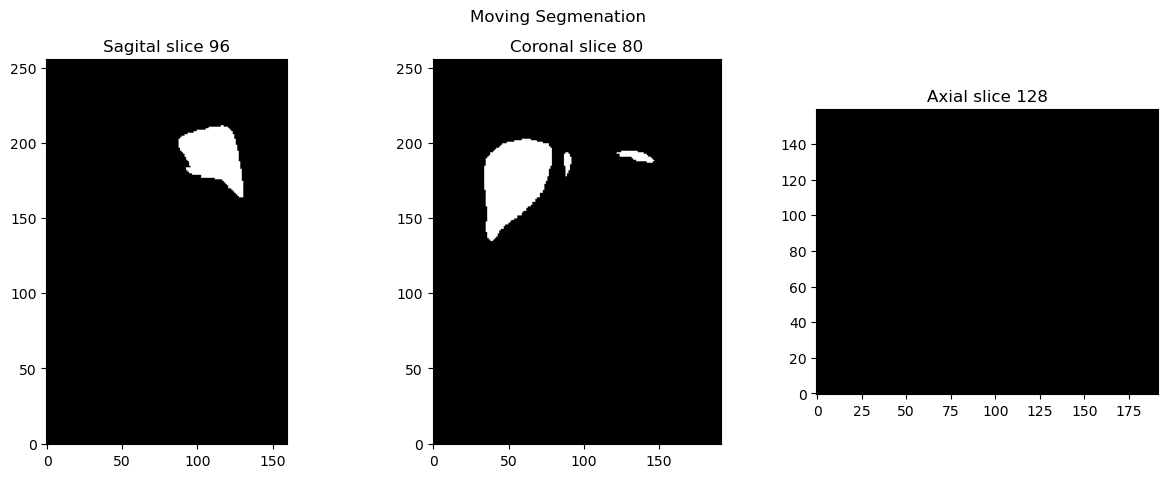

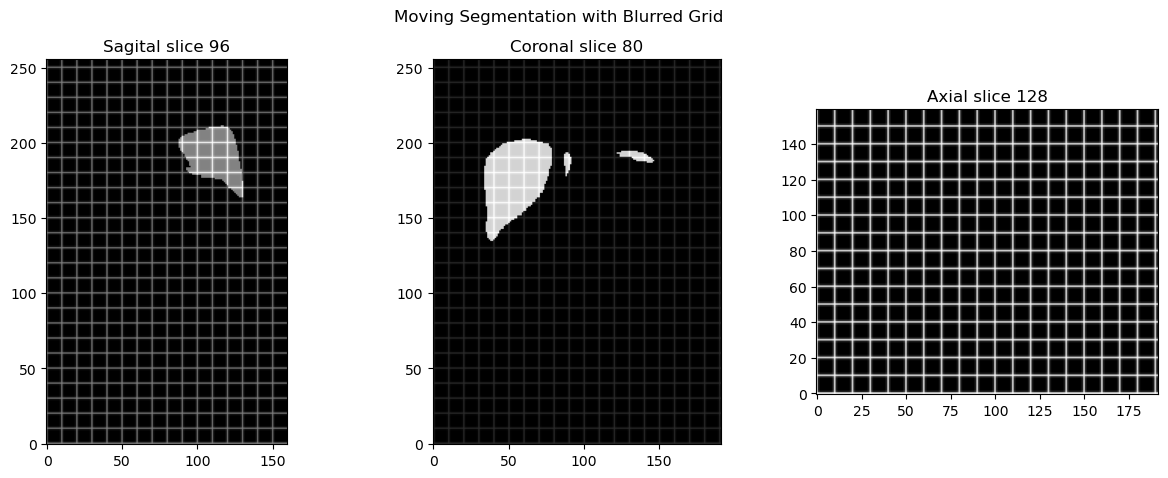

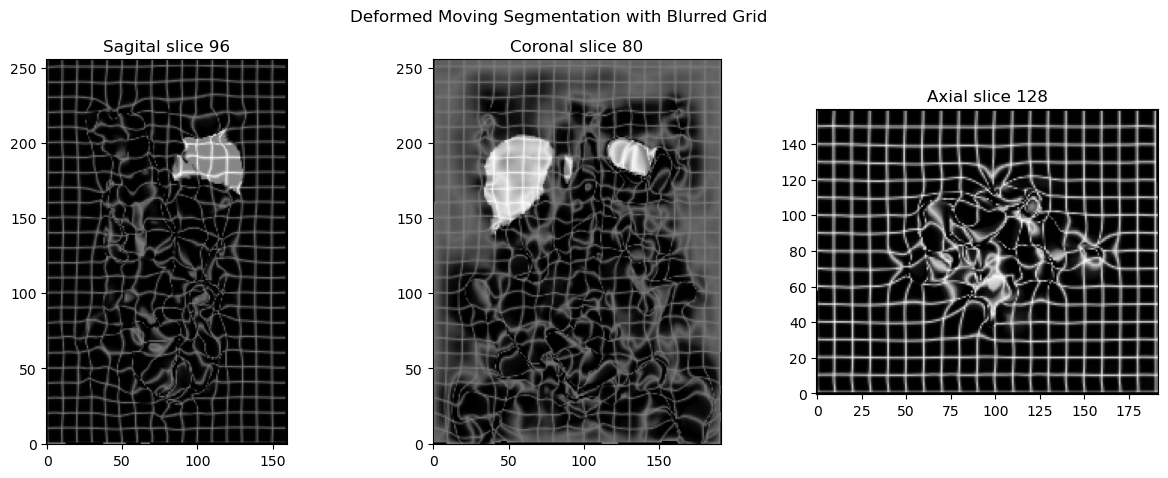

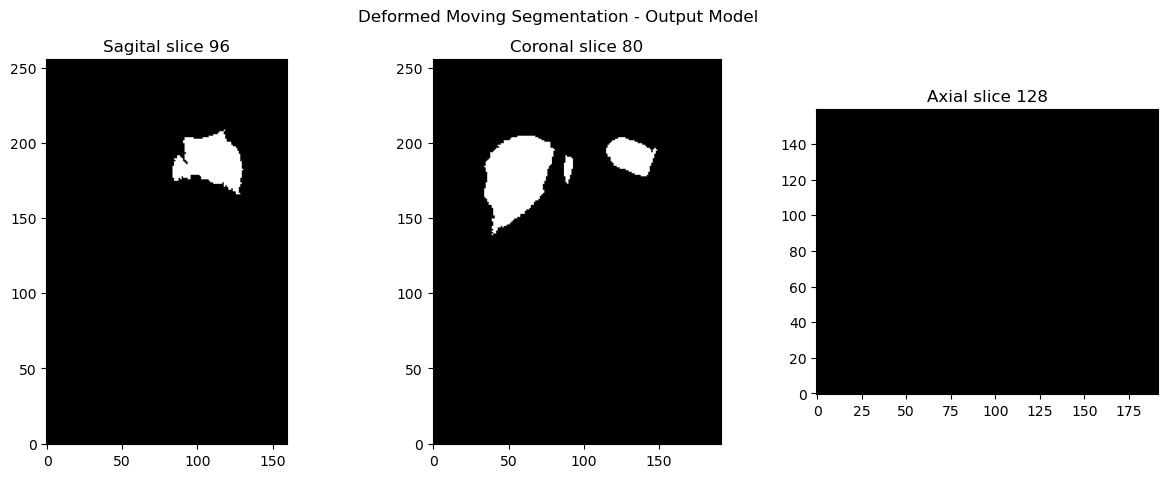

In [12]:
main(img2_0_paths, seg2_0_paths, w_img_0_paths, w_seg_0_paths, flow_4d_0_paths, 'warped_image_with_grid_0.nii.gz')


In [13]:
#main(img2_54_paths, seg2_54_paths, flow_4d_54_paths, 'warped_image_with_grid_54.nii.gz')

##### VTN

Deformation field in nii:  (192, 160, 256, 3)
Deformation field in nii:  (192, 160, 256, 3)


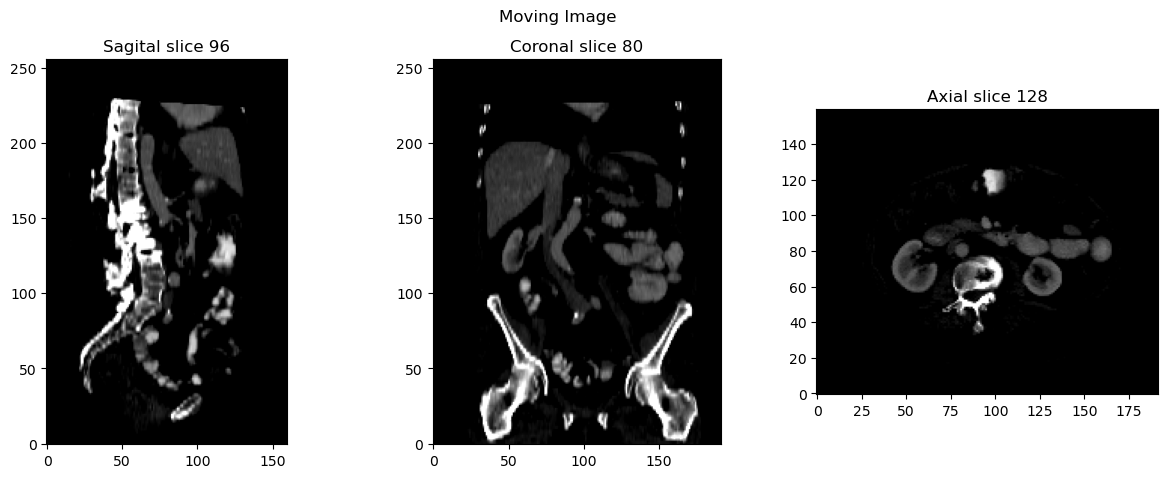

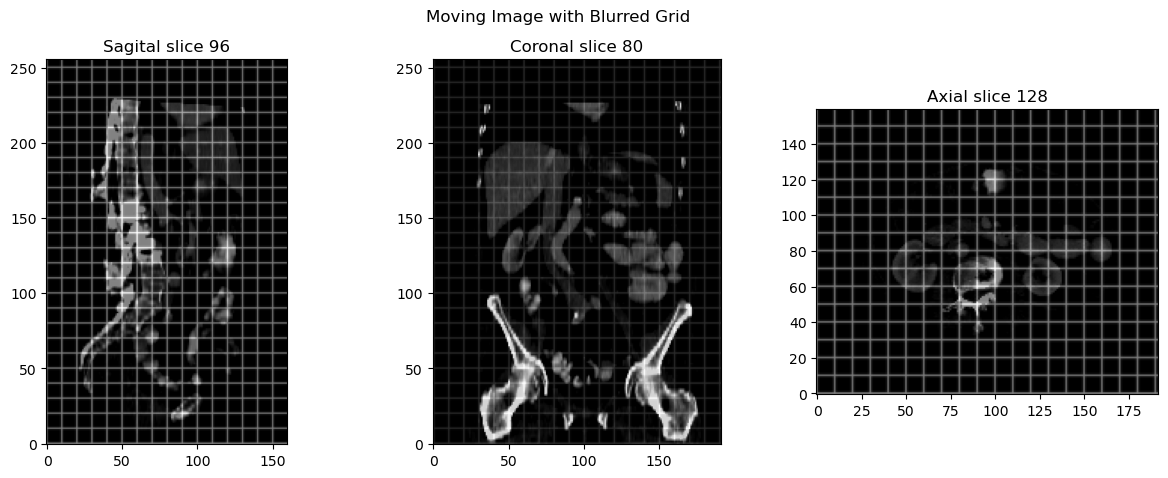

(192, 160, 256)
(192, 160, 256)


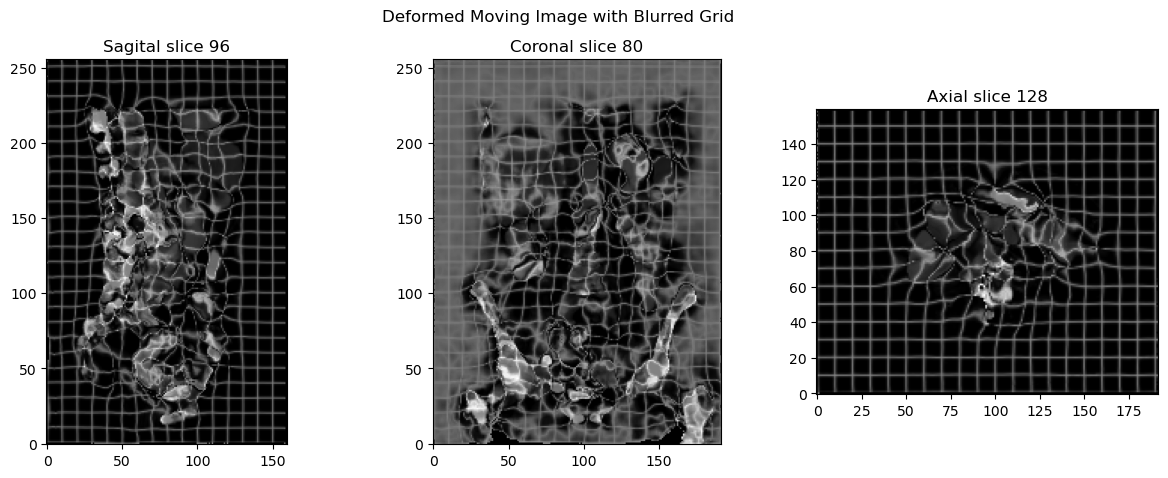

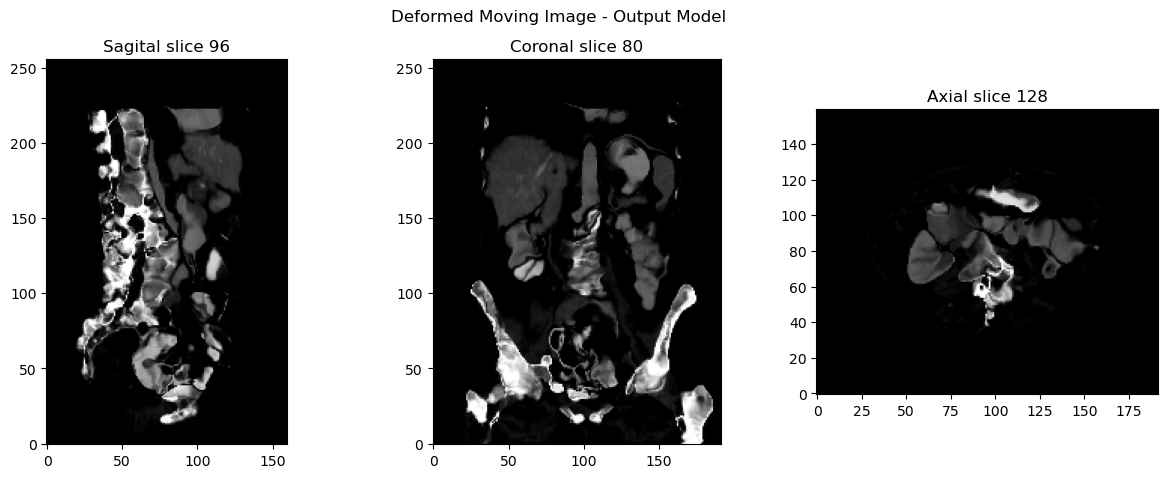

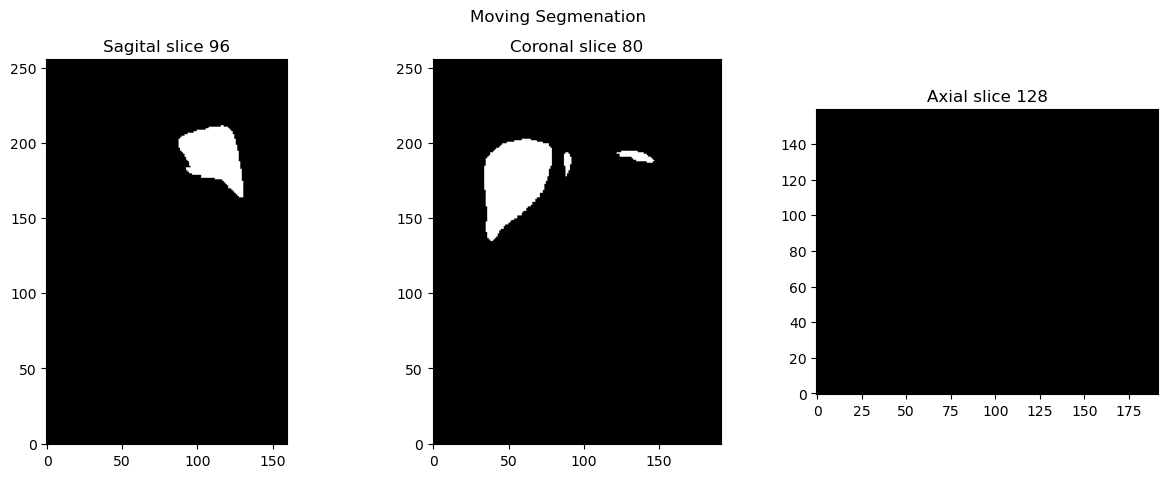

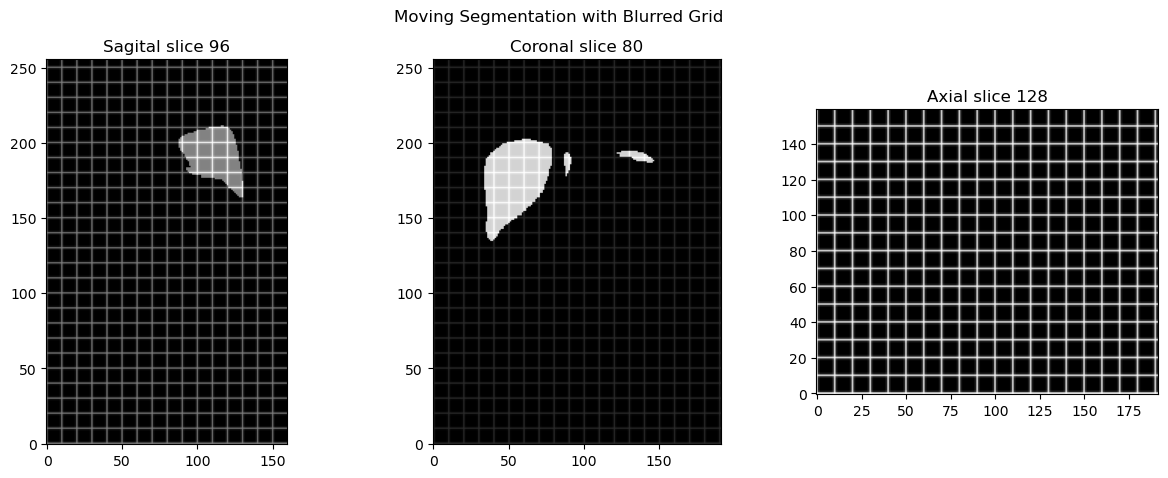

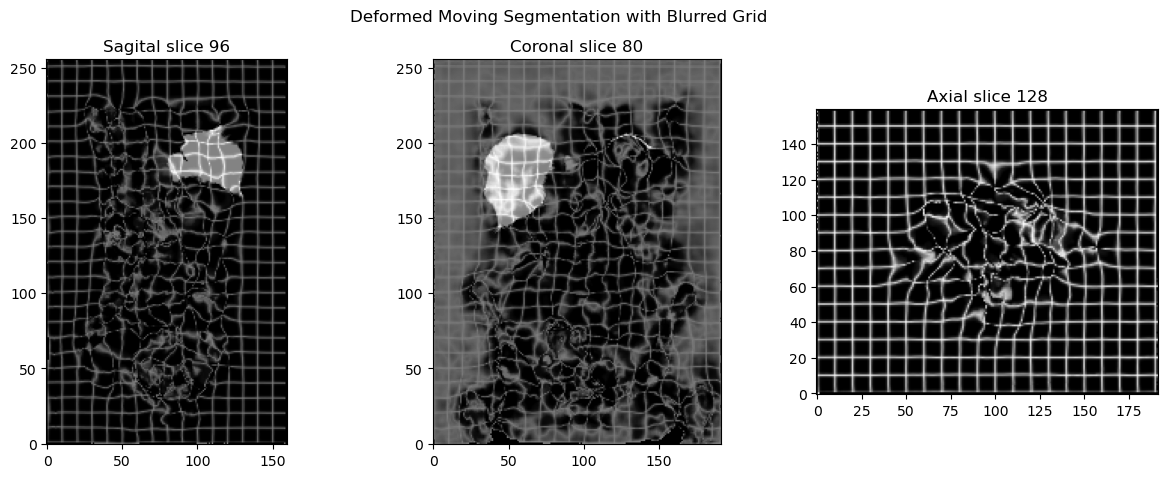

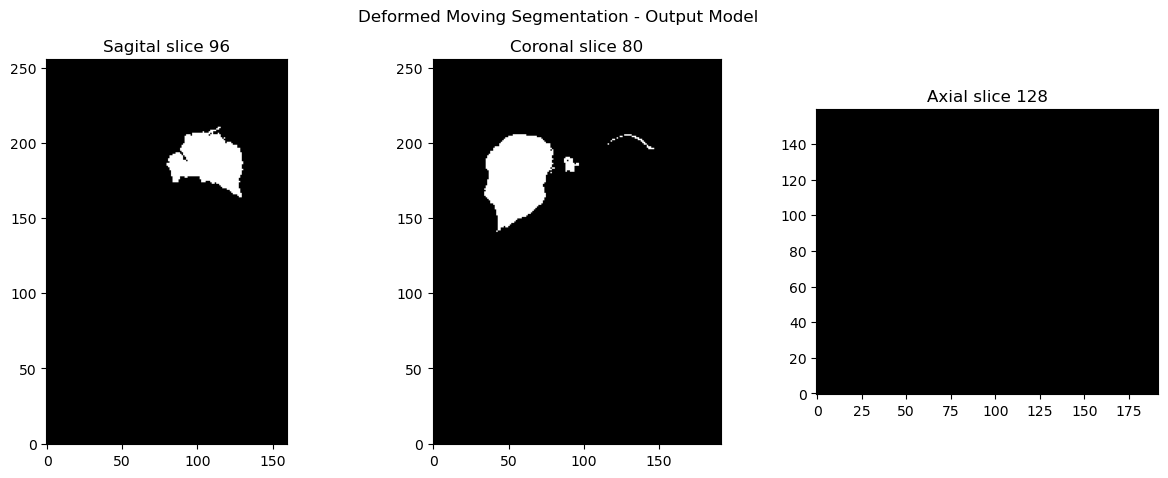

In [14]:
# VTN Directory
vtn_directory    = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Aug06-211340_Abtrain_VTNx3___/'
vtn_defGrid_dir  = vtn_directory + 'defGrid_figures/'
image_paths   = get_file_paths(vtn_directory)
img2_paths    = image_paths['img2.nii.gz']
seg2_paths    = image_paths['seg2.nii.gz']
w_img_paths   = image_paths['w_img.nii.gz']
w_seg_paths   = image_paths['w_seg.nii.gz']
flow_4d_paths = image_paths['flow_4d.nii.gz']

img2_0_paths    = img2_paths[0]
seg2_0_paths    = seg2_paths[0]
w_img_0_paths   = w_img_paths[0]
w_seg_0_paths   = w_seg_paths[0]
flow_4d_0_paths = flow_4d_paths[0]

img2_54_paths    = img2_paths[54]
seg2_54_paths    = seg2_paths[54]
w_img_54_paths   = w_img_paths[54]
w_seg_54_paths   = w_seg_paths[54]
flow_4d_54_paths = flow_4d_paths[54]

main(img2_0_paths, seg2_0_paths, w_img_0_paths, w_seg_0_paths, flow_4d_0_paths, 'warped_image_with_grid_0.nii.gz')


##### TSM

Deformation field in nii:  (192, 160, 256, 3)
Deformation field in nii:  (192, 160, 256, 3)


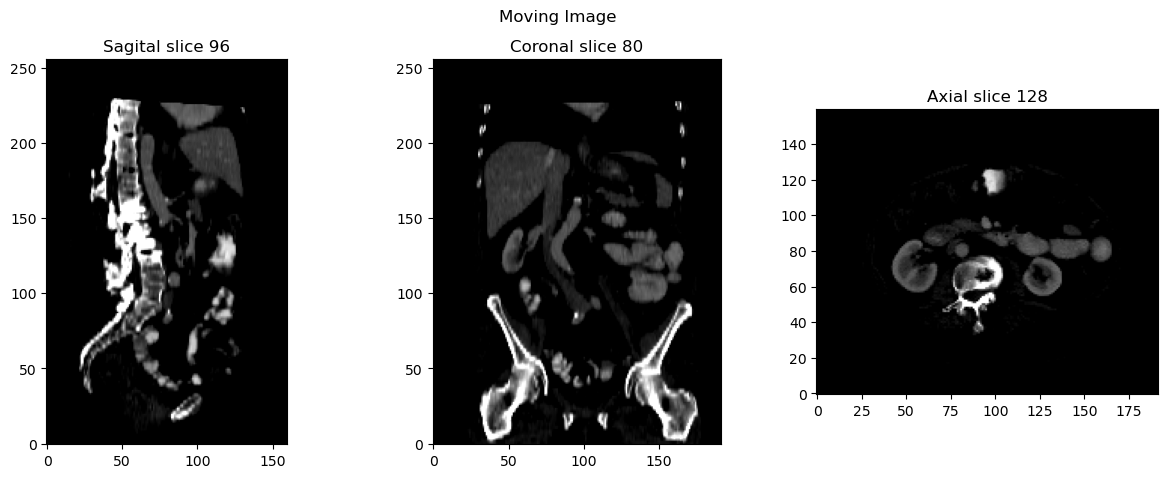

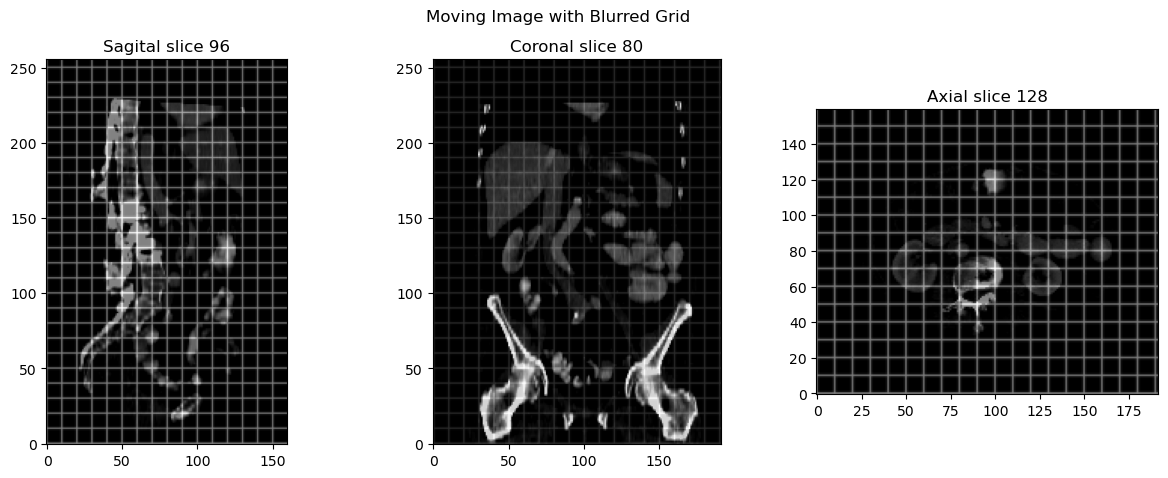

(192, 160, 256)
(192, 160, 256)


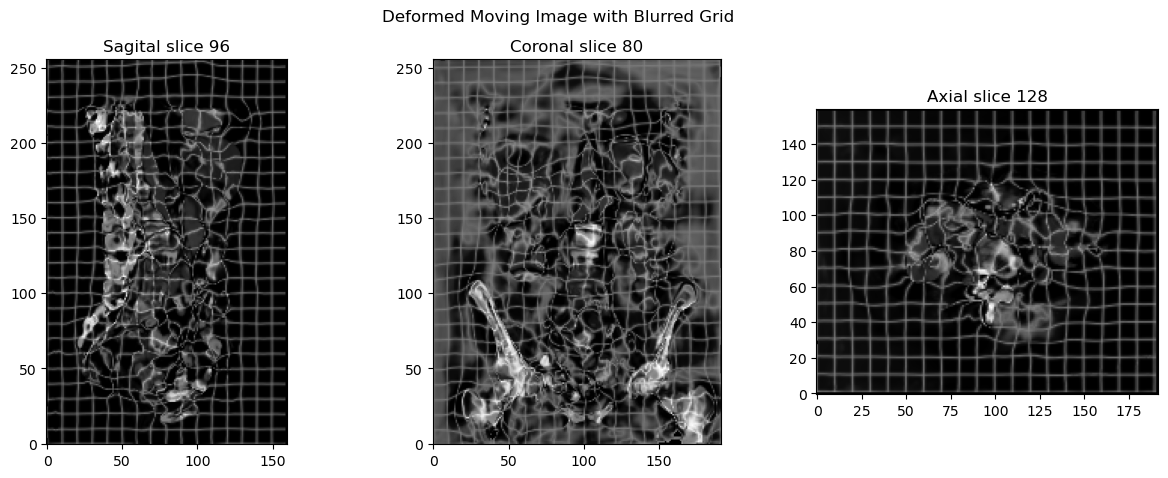

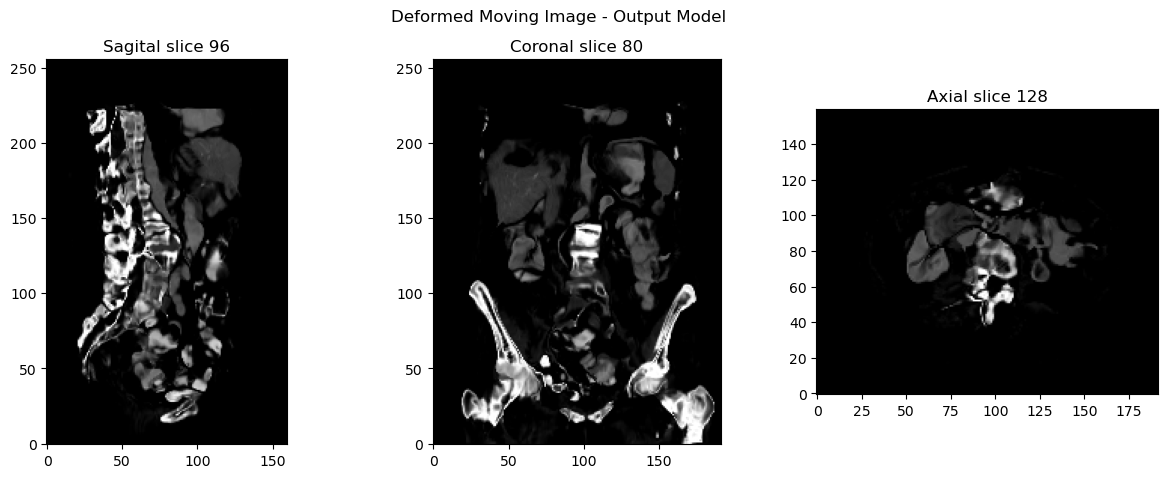

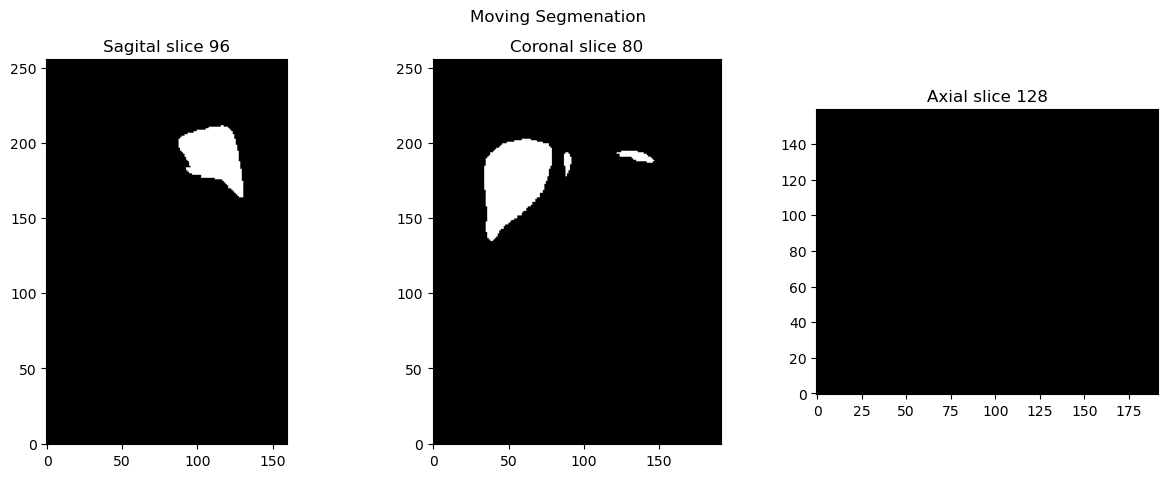

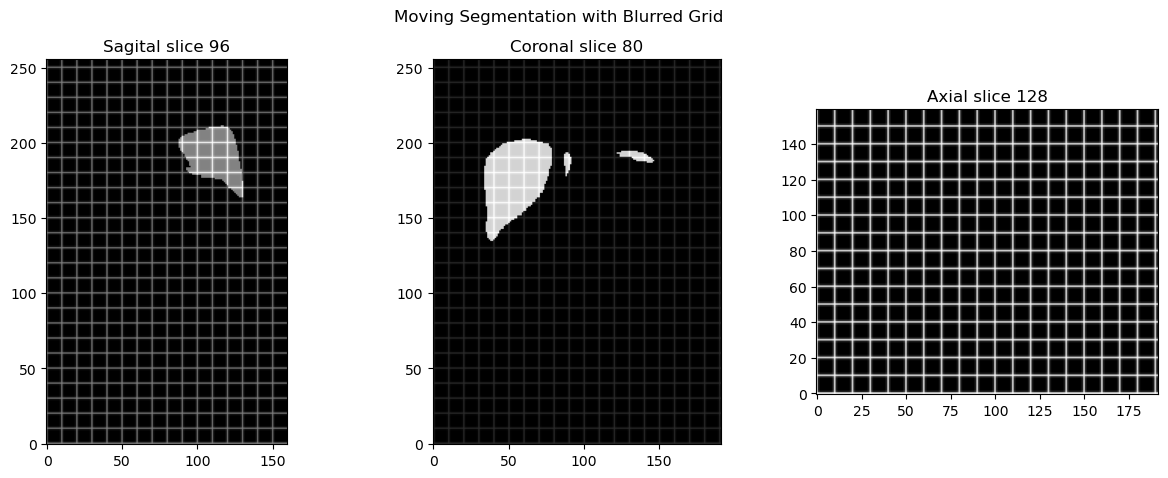

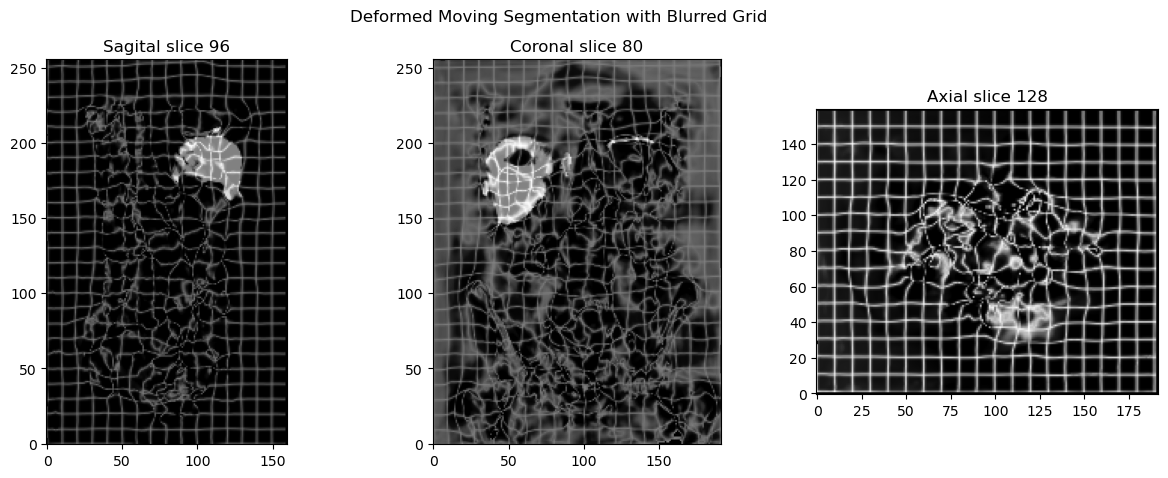

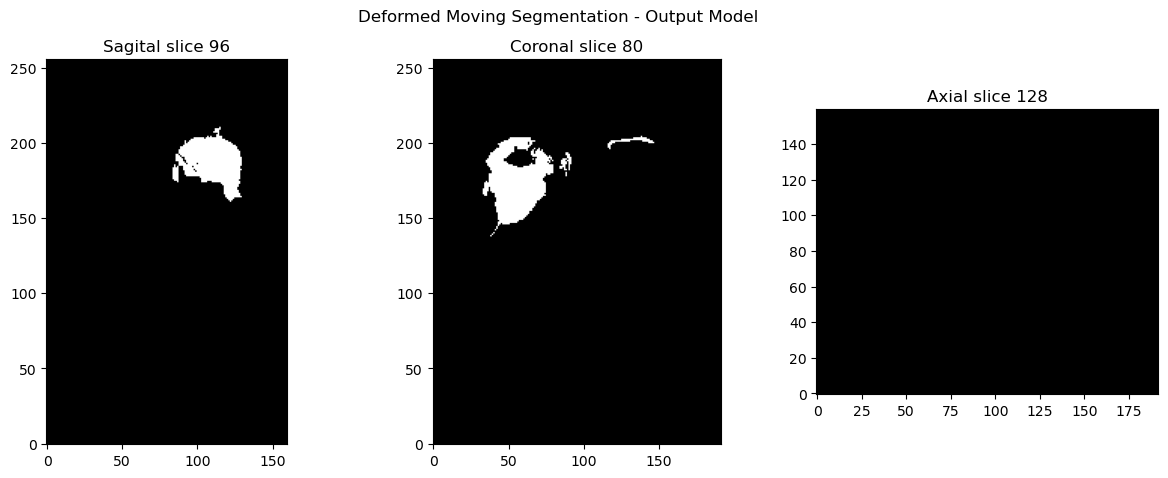

In [15]:
# TSM Directory
tsm_directory    = '/data/groups/beets-tan/l.estacio/Med_Align_Net/Aug07-042242_Abtrain_TSMx1___/'
tsm_defGrid_dir  = tsm_directory + 'defGrid_figures/'
image_paths   = get_file_paths(tsm_directory)
img2_paths    = image_paths['img2.nii.gz']
seg2_paths    = image_paths['seg2.nii.gz']
w_img_paths   = image_paths['w_img.nii.gz']
w_seg_paths   = image_paths['w_seg.nii.gz']
flow_4d_paths = image_paths['flow_4d.nii.gz']

img2_0_paths    = img2_paths[0]
seg2_0_paths    = seg2_paths[0]
w_img_0_paths   = w_img_paths[0]
w_seg_0_paths   = w_seg_paths[0]
flow_4d_0_paths = flow_4d_paths[0]

img2_54_paths    = img2_paths[54]
seg2_54_paths    = seg2_paths[54]
w_img_54_paths   = w_img_paths[54]
w_seg_54_paths   = w_seg_paths[54]
flow_4d_54_paths = flow_4d_paths[54]
main(img2_0_paths, seg2_0_paths, w_img_0_paths, w_seg_0_paths, flow_4d_0_paths, 'warped_image_with_grid_0.nii.gz')

#### Elastix

Deformation field in nii:  (192, 160, 256, 3)
Deformation field in nii:  (192, 160, 256, 3)


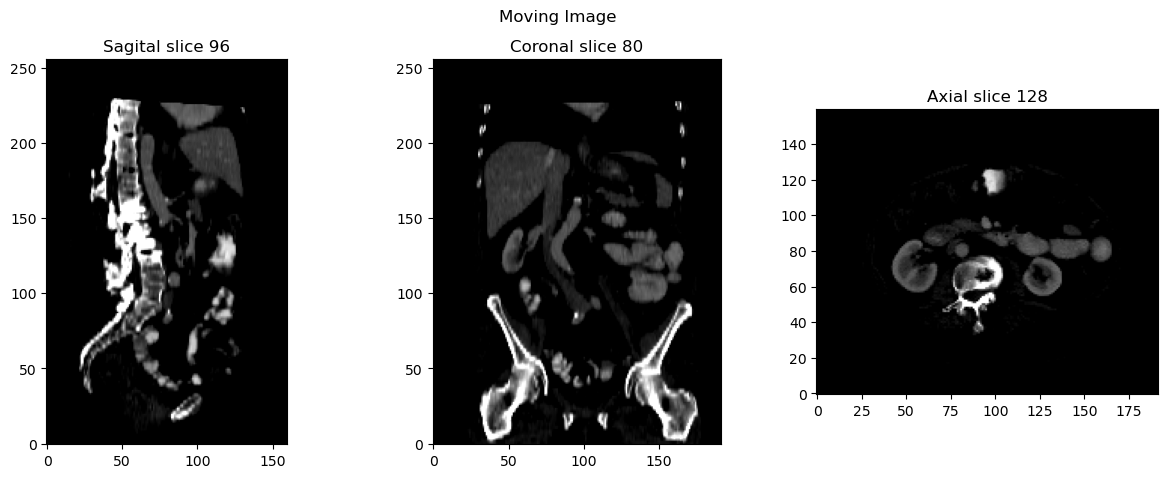

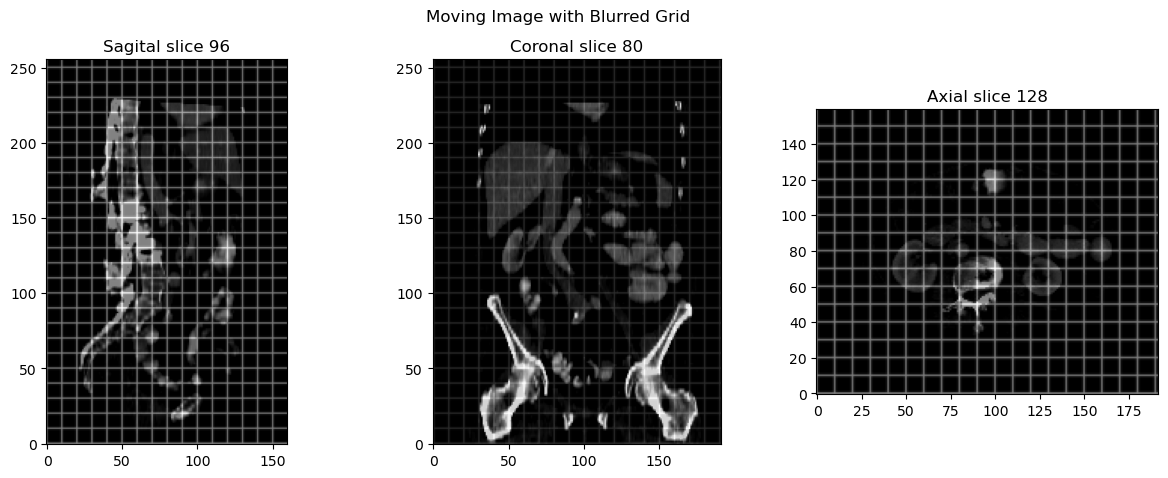

(192, 160, 256)
(192, 160, 256)


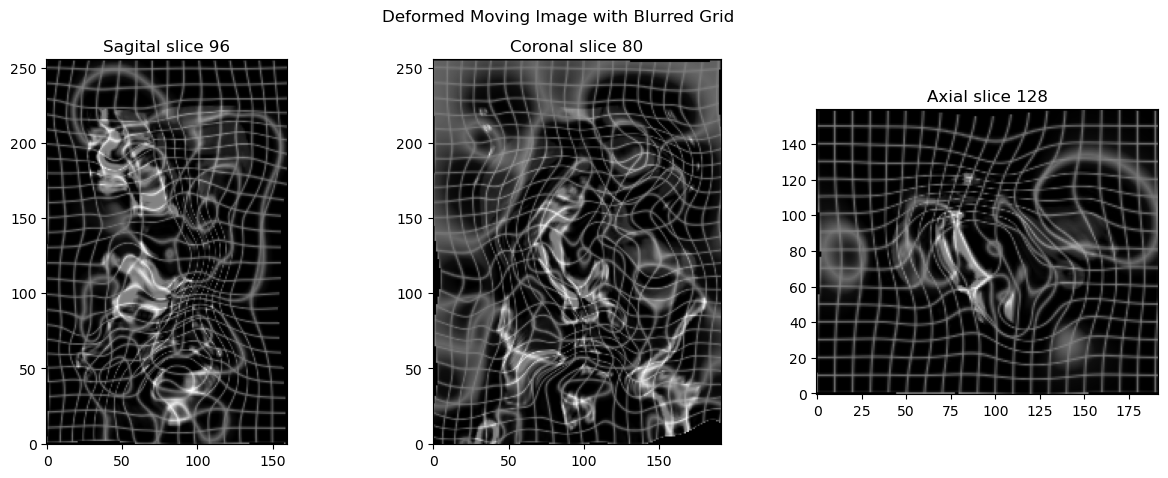

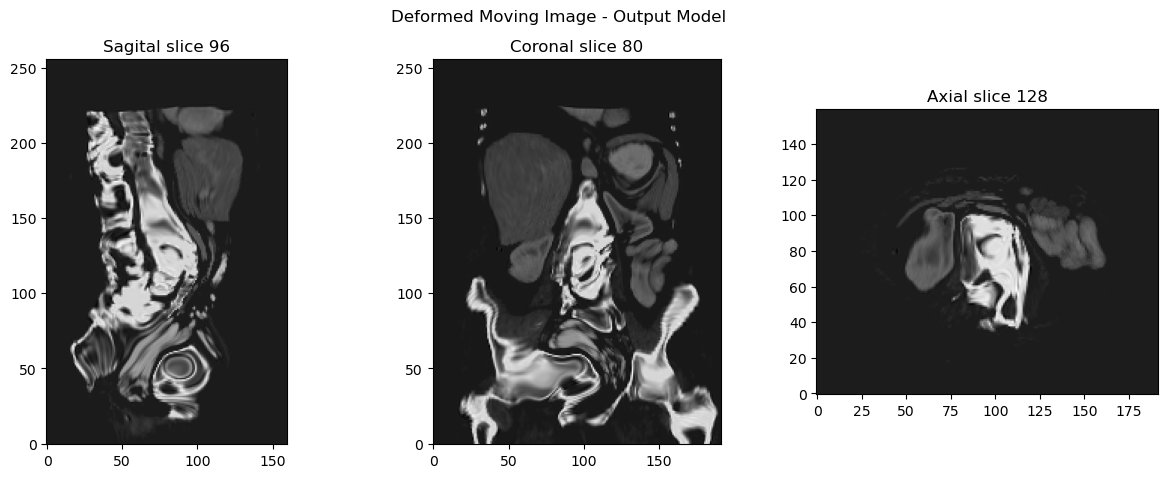

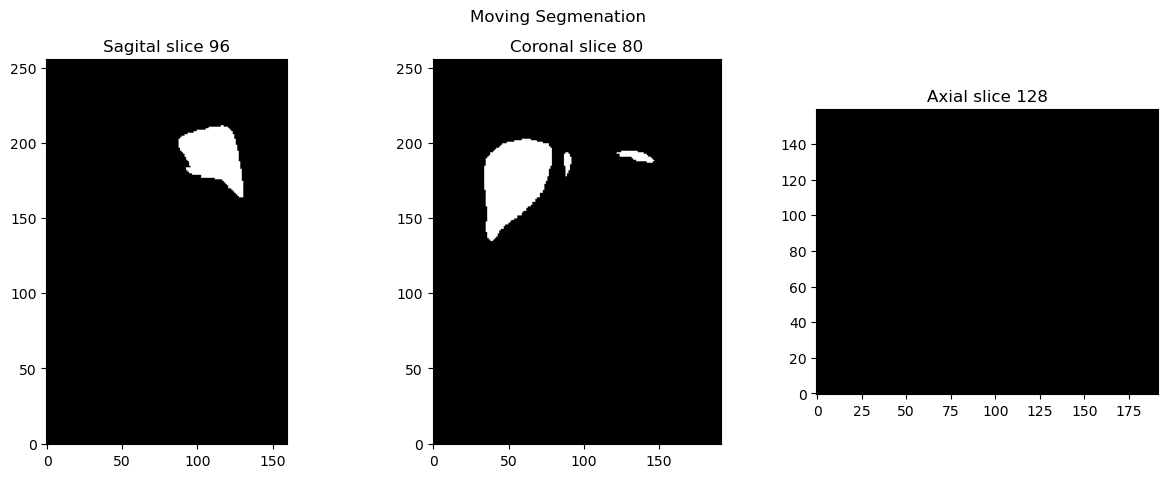

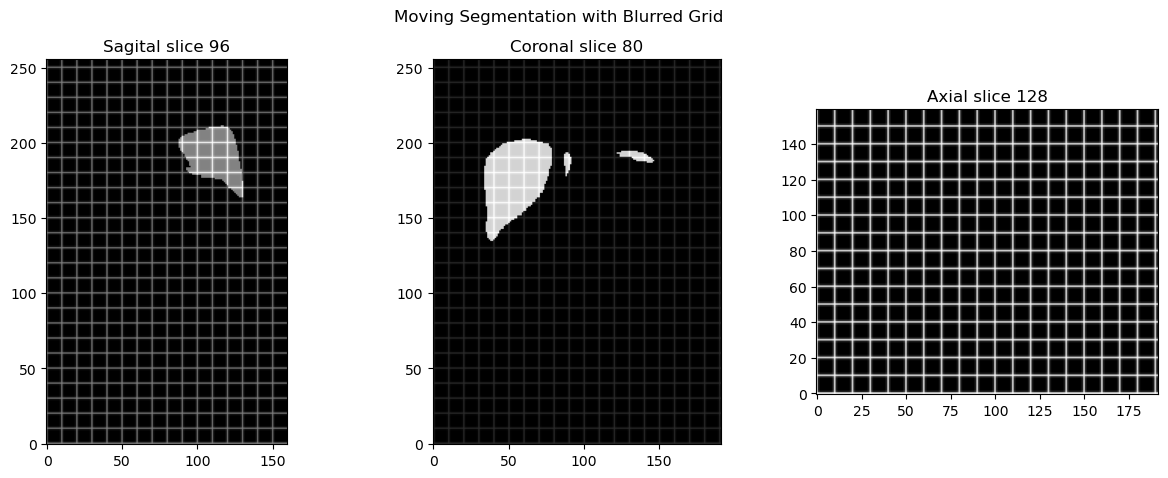

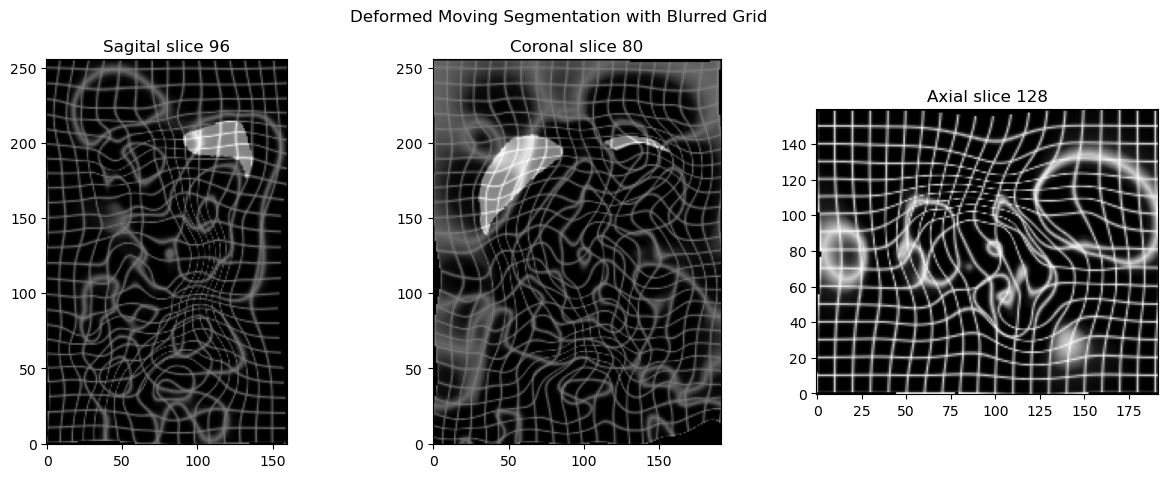

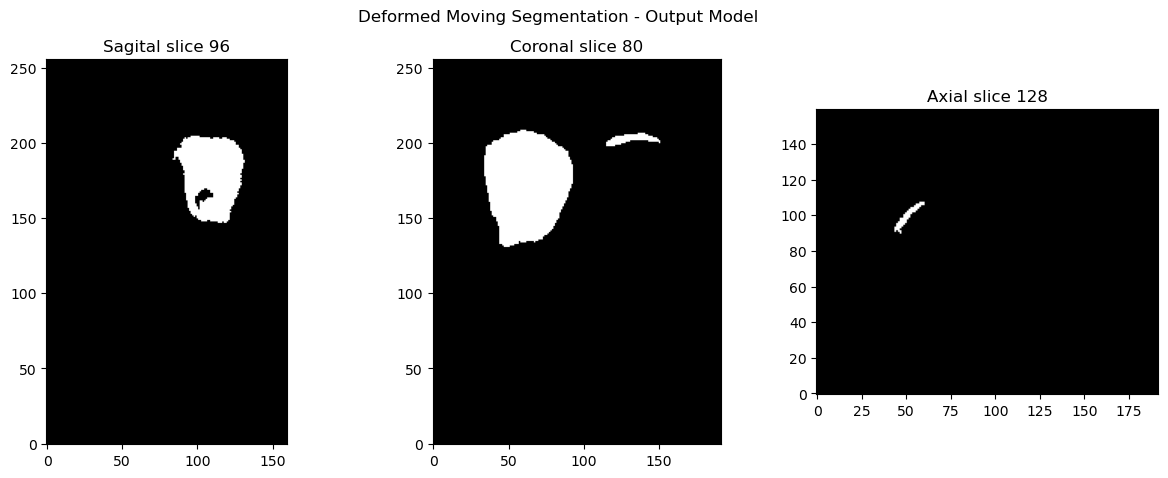

In [16]:
# VoxelMorph Directory
elx_directory    = '/data/groups/beets-tan/l.estacio/Med_Align_Net/elastix_Abd/'
elx_defGrid_dir  = elx_directory + 'defGrid_figures/'
image_paths   = get_file_paths(elx_directory)
img2_paths    = image_paths['img2.nii.gz']
seg2_paths    = image_paths['seg2.nii.gz']
w_img_paths   = image_paths['w_img.nii.gz']
w_seg_paths   = image_paths['w_seg.nii.gz']
flow_4d_paths = image_paths['flow_4d.nii.gz']

img2_0_paths    = img2_paths[0]
seg2_0_paths    = seg2_paths[0]
w_img_0_paths   = w_img_paths[0]
w_seg_0_paths   = w_seg_paths[0]
flow_4d_0_paths = flow_4d_paths[0]

img2_54_paths    = img2_paths[54]
seg2_54_paths    = seg2_paths[54]
w_img_54_paths   = w_img_paths[54]
w_seg_54_paths   = w_seg_paths[54]
flow_4d_54_paths = flow_4d_paths[54]
main(img2_0_paths, seg2_0_paths, w_img_0_paths, w_seg_0_paths, flow_4d_0_paths, 'warped_image_with_grid_0.nii.gz')

#### ANTs

Deformation field in nii:  (192, 160, 256, 3)
Deformation field in nii:  (192, 160, 256, 3)


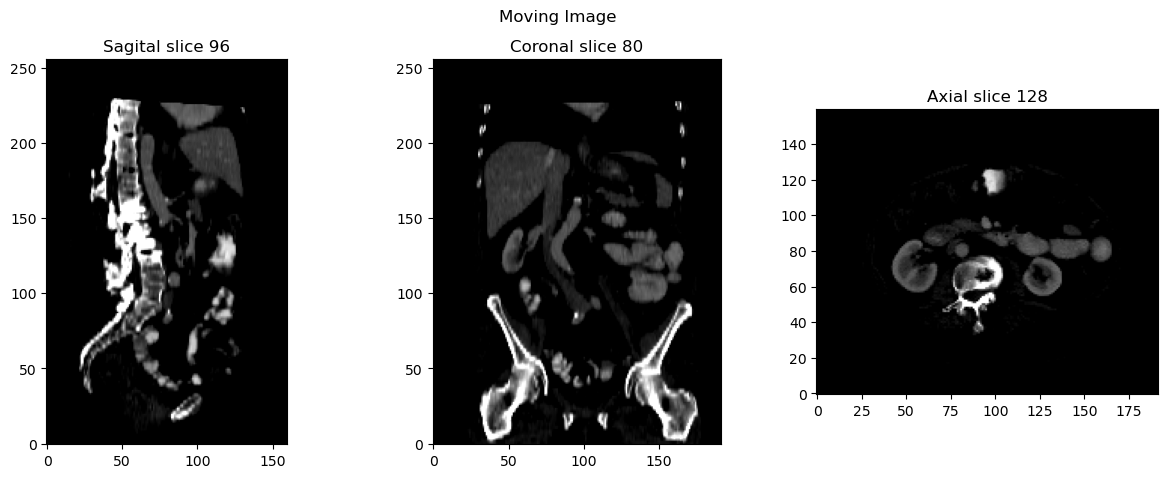

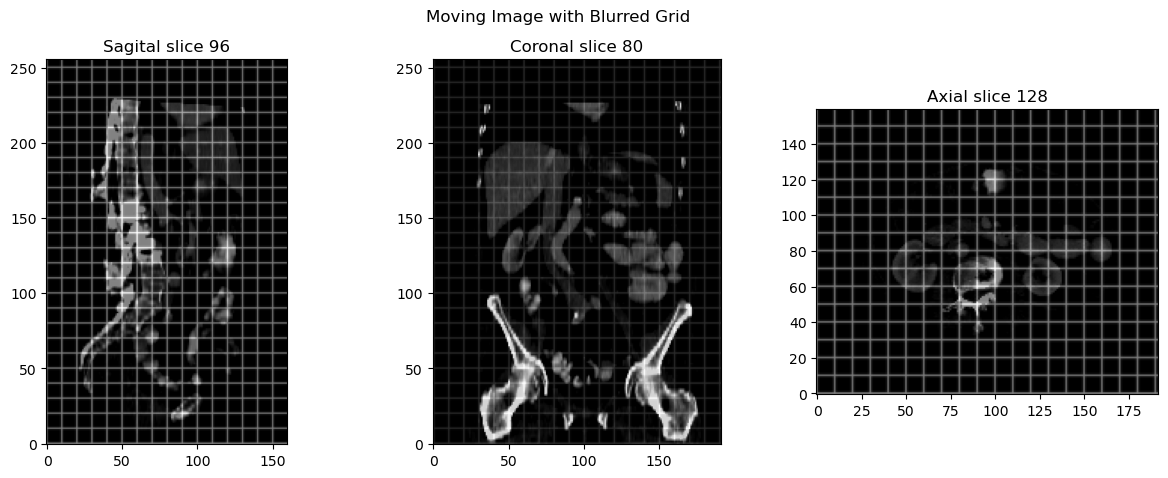

(192, 160, 256)
(192, 160, 256)


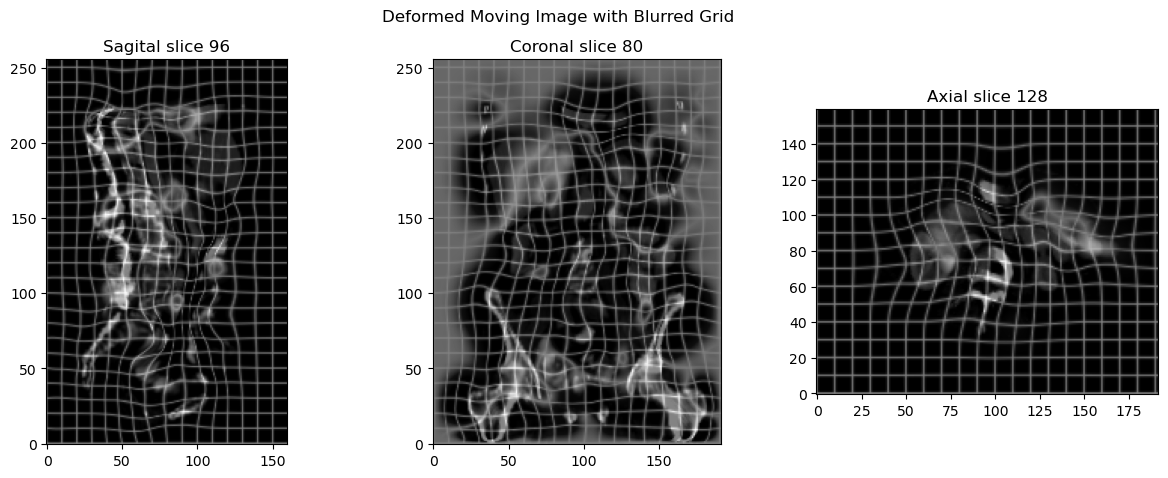

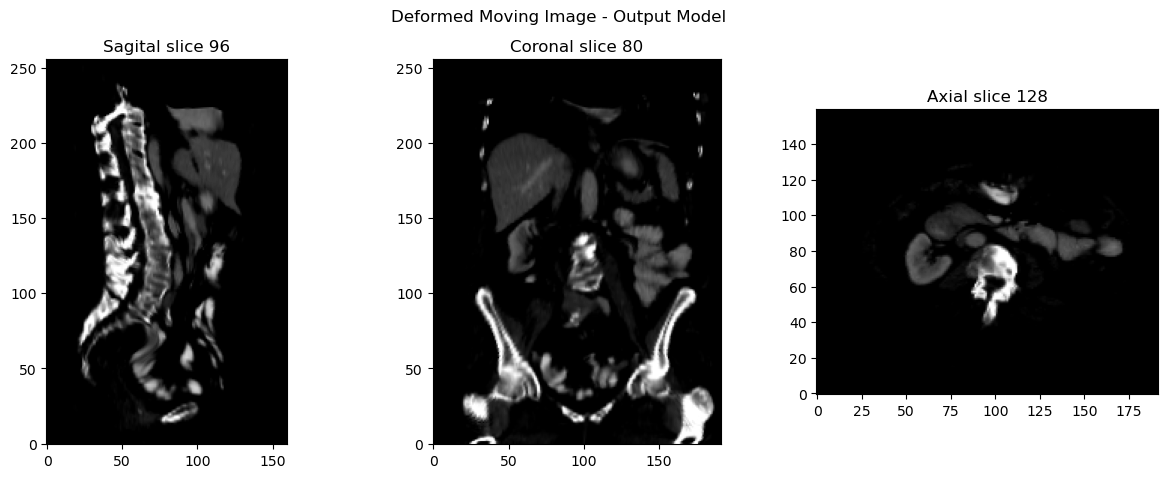

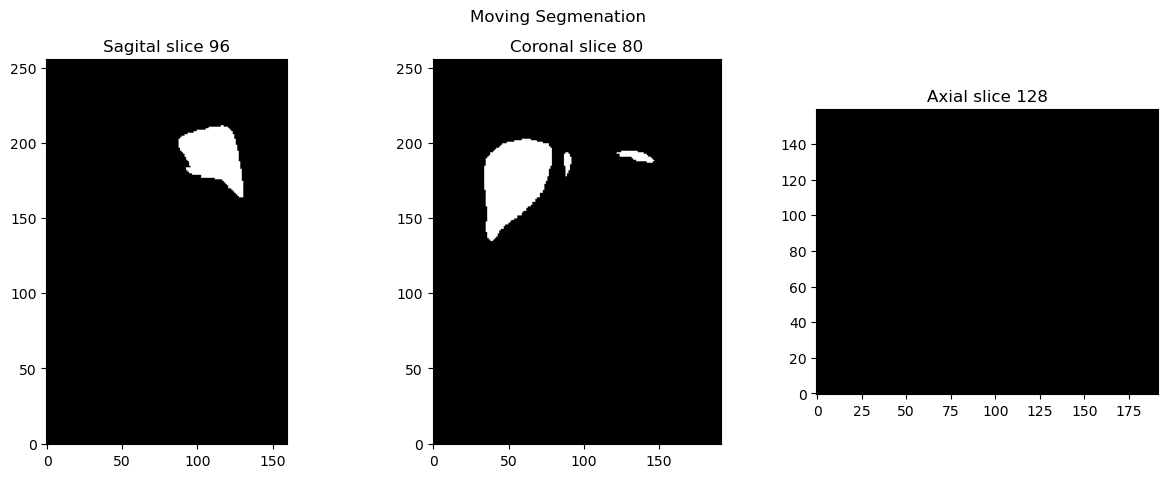

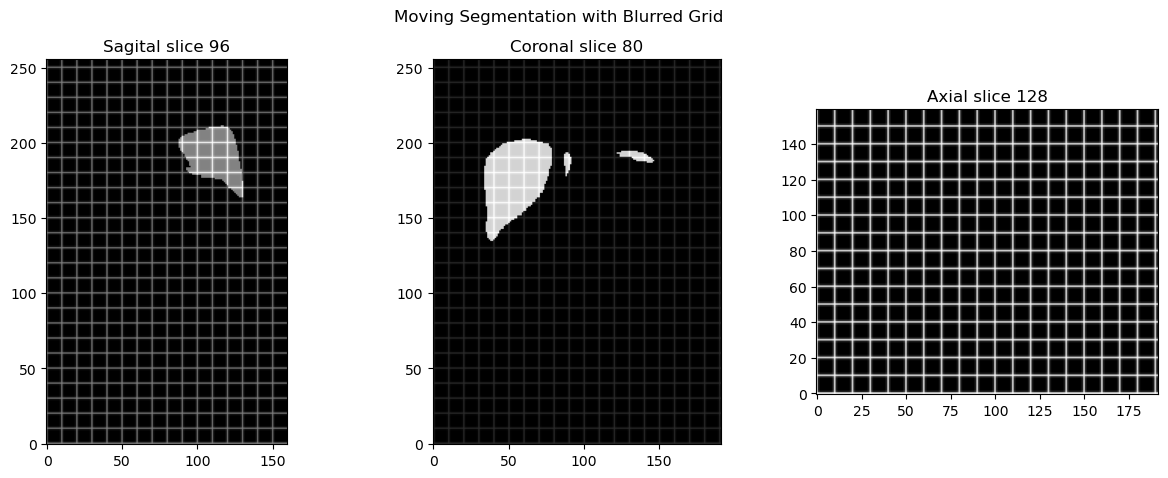

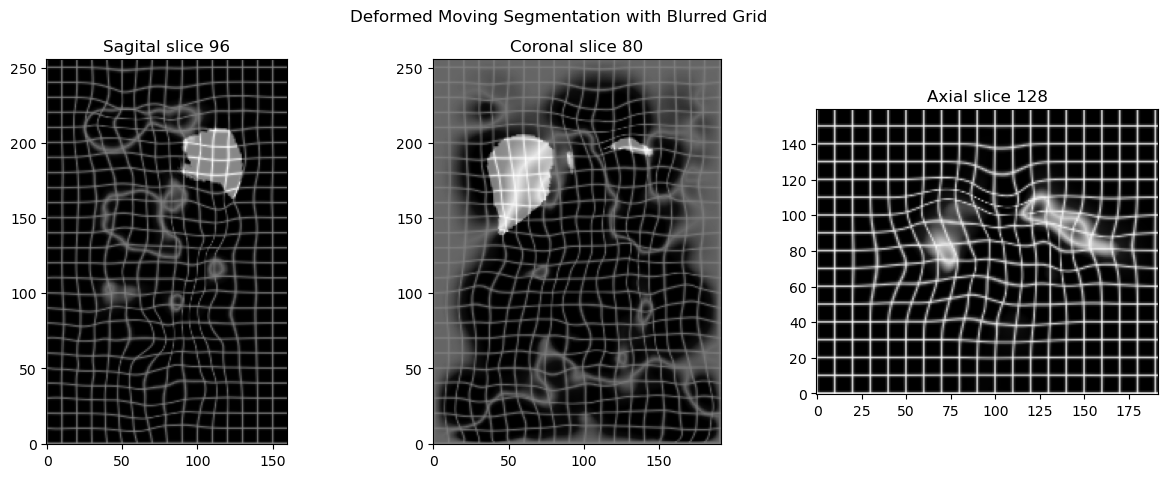

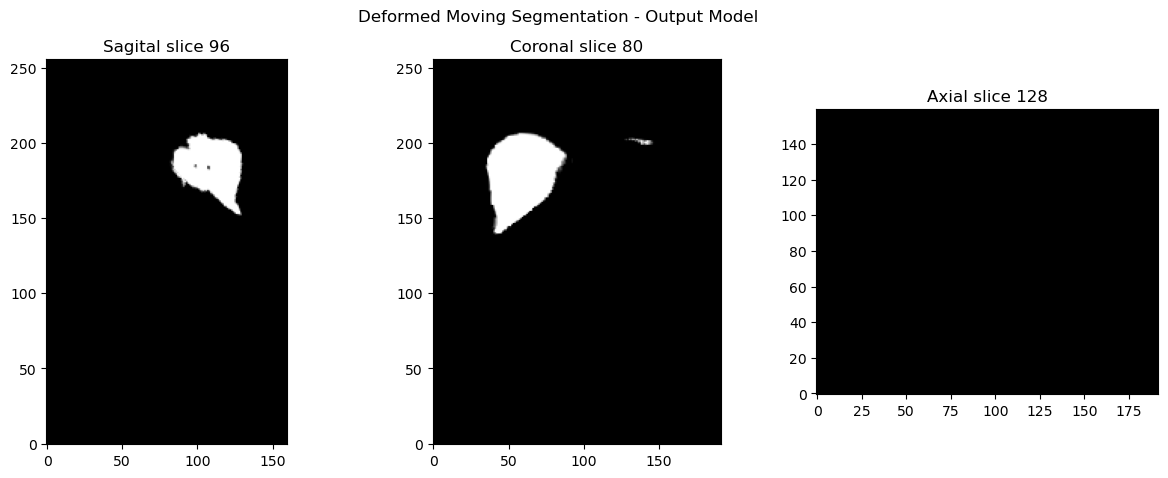

In [18]:
# ANTs Directory
ant_directory    = '/data/groups/beets-tan/l.estacio/Med_Align_Net/ants_Abd/'
ant_defGrid_dir  = ant_directory + 'defGrid_figures/'
image_paths   = get_file_paths(ant_directory)
img2_paths    = image_paths['img2.nii.gz']
seg2_paths    = image_paths['seg2.nii.gz']
w_img_paths   = image_paths['w_img.nii.gz']
w_seg_paths   = image_paths['w_seg.nii.gz']
flow_4d_paths = image_paths['flow_4d.nii.gz']

img2_0_paths    = img2_paths[0]
seg2_0_paths    = seg2_paths[0]
w_img_0_paths   = w_img_paths[0]
w_seg_0_paths   = w_seg_paths[0]
flow_4d_0_paths = flow_4d_paths[0]

img2_54_paths    = img2_paths[54]
seg2_54_paths    = seg2_paths[54]
w_img_54_paths   = w_img_paths[54]
w_seg_54_paths   = w_seg_paths[54]
flow_4d_54_paths = flow_4d_paths[54]
main(img2_0_paths, seg2_0_paths, w_img_0_paths, w_seg_0_paths, flow_4d_0_paths, 'warped_image_with_grid_0.nii.gz')